In [1]:
import pandas as pd 
df=pd.read_csv('classification.csv')

# importation

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate

# 1) Chargement et nettoyage du DataFrame

In [4]:

try:
    df
except NameError:
    df = pd.DataFrame(columns=[
        "filename_lr", "age", "sex", "height", "weight",
        "Myocardial Infarction (MI)", "ST/T Change (STTC)",
        "Conduction Disturbance (CD)", "Hypertrophy (HYP)", "Normal (NORM)"
    ])

image_dir = 'records100'
df["filename_lr"] = df["filename_lr"].apply(lambda p: os.path.join(image_dir, p.split("/")[-1] + ".png"))
df = df[df["filename_lr"].apply(os.path.exists)].reset_index(drop=True)

target_columns = [
    "Myocardial Infarction (MI)", "ST/T Change (STTC)",
    "Conduction Disturbance (CD)", "Hypertrophy (HYP)", "Normal (NORM)"
]

# 2) Transformation des images 

In [ ]:

image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Image (RGB, taille variable)



    ↓


Redimensionnée à 128x128


    ↓


Convertie en niveau de gris (mais avec 3 canaux identiques)


    ↓


Transformée en tenseur (3, 128, 128), valeurs entre [0, 1]



    ↓
Normalisée à une distribution centrée autour de 0 (valeurs entre [-1, 1])





# 3) Dataset 

In [ ]:
class ECGDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df["filename_lr"].tolist() #liste de paths 
        self.tab = torch.tensor(df[["age", "sex", "height", "weight"]].values, dtype=torch.float32) #rendre les donneés tabulaires en tensor avec meme type 
        self.labels = torch.tensor(df[target_columns].values, dtype=torch.float32) #same pour les sorties 
        self.transform = transform

    def __len__(self):
        return len(self.paths)#len de la liste de paths

    def __getitem__(self, idx):
        path = self.paths[idx]
        try:
            img = Image.open(path).convert("RGB") #ouvrir l'image et la convertir en RGB en cas de grayscale
        except (UnidentifiedImageError, OSError):
            return None
        if self.transform:
            img = self.transform(img) #appliquer la transformation sur l'image
        return img, self.tab[idx], self.labels[idx]     #retourner l'image, les données tabulaires et les labels

def collate_fn(batch):
    batch = [b for b in batch if b is not None] #enlever les None
    return default_collate(batch) if batch else [] #retourner le batch sans les None

#  4) Préparation des DataLoaders 

In [ ]:
df_train = df.sample(frac=0.8, random_state=42) #80% pour l'entrainement
df_val = df.drop(df_train.index) #20% pour la validation

train_ds = ECGDataset(df_train, transform=image_transform) #créer le dataset d'entrainement
val_ds = ECGDataset(df_val, transform=image_transform) #créer le dataset de validation

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn) #créer le dataloader d'entrainement
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn) #créer le dataloader de validation

DataFrame complet (df)
    ↓


Séparation en train/validation


    • df_train = df.sample(frac=0.8, random_state=42)
    • df_val   = df.drop(df_train.index)


    ↓



Création des Dataset PyTorch


    • train_ds = ECGDataset(df_train, transform=…)
    • val_ds   = ECGDataset(df_val,   transform=…)

    
    ↓


Création des DataLoader


    • train_loader = DataLoader(
          train_ds,
          batch_size=32,
          shuffle=True,
          collate_fn=collate_fn
      )
      
    • val_loader   = DataLoader(
          val_ds,
          batch_size=32,
          shuffle=False,
          collate_fn=collate_fn
      )



# 5) Modèle CNN personnalisé

***Convolution « classique » vs « depthwise »**

nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)


Pour chaque canal de sortie, on apprend un filtre 3×3 appliqué à tous les canaux d’entrée.

**Nombre de paramètres = (in_c×kernel_h×kernel_w)×out_c+out_c (biais)**

→ gros quand in_c et out_c sont grands.

vs 


nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c)
  
  **Nombre de paramètres = (1 canal×3×3)×in_c+in_c (biais)=9in_c+in_c=10in_c***

-->Chaque canal d’entrée est convolué par son propre filtre 3×3, indépendamment des autres canaux.

In [ ]:
class LightCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        def dw_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c),#in_c → in_c : nombre de canaux en entrée et sortie identique ,kernel_size=3 : filtre 3×3,padding=1 : ajoute 1 pixel de chaque côté pour conserver la même taille spatiale,groups=in_c : depthwise convolution (un filtre par canal): réduit drastiquement le nombre de paramètres.
                nn.BatchNorm2d(in_c), #Normalisation de batch sur les in_c canaux pour stabiliser et accélérer l’entraînement.
                nn.ReLU(), #Fonction d’activation ReLU pour introduire de la non-linéarité.
                nn.Conv2d(in_c, out_c, kernel_size=1), # Coût en paramètres :in_c×out_c+out_c(biais) ,mélange de canaux
                nn.BatchNorm2d(out_c), #Normalisation de batch sur les out_c canaux pour stabiliser et accélérer l’entraînement.
                nn.ReLU(),
                nn.MaxPool2d(2) #Réduction de la taille spatiale par un facteur de 2 (16x16) pour réduire la complexité computationnelle et extraire des caractéristiques plus abstraites.
            )
        self.conv1 = dw_conv(3, 16) #3 canaux d'entrée (RGB) et 16 canaux de sortie
        self.conv2 = dw_conv(16, 32) #16 canaux d'entrée et 32 canaux de sortie
        self.conv3 = dw_conv(32, 64) #32 canaux d'entrée et 64 canaux de sortie

        self.cnn_fc = nn.Sequential(
            nn.Flatten(), #Aplatie le tenseur de (batch, 64, 16, 16) → (batch, 64*16*16)
            nn.Linear(64 * 16 * 16, 256), #Couche entièrement connectée réduisant de 64*16*16=16384 dimensions à 256.
            nn.ReLU(),
            nn.Dropout(dropout_rate) #Applique un abandon de dropout_rate (ici 0.3) pour réduire le sur‑apprentissage.
        )

        self.mlp = nn.Sequential(
            nn.Linear(4, 16), #4 features tabulaires (age, sex, height, weight) → 16 dimensions
            nn.BatchNorm1d(16), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 32), 
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 + 32, 64),#Combine les 256 sorties du CNN et les 32 du MLP (256 + 32 = 288) 
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, len(target_columns)) #64 → 5 (nombre de classes cibles)
        )

    def forward(self, img, tab):
        x = self.conv1(img)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.cnn_fc(x)
        y = self.mlp(tab)
        return self.classifier(torch.cat([x, y], dim=1))

# 6) Entraînement

c:\Users\pc\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/13 — Train Loss 0.4176 | Train Acc 0.8214 — Val Loss 0.3336 | Val Acc 0.8478
Epoch 2/13 — Train Loss 0.3260 | Train Acc 0.8573 — Val Loss 0.3091 | Val Acc 0.8589
Epoch 3/13 — Train Loss 0.3037 | Train Acc 0.8675 — Val Loss 0.2975 | Val Acc 0.8668
Epoch 4/13 — Train Loss 0.2946 | Train Acc 0.8717 — Val Loss 0.2985 | Val Acc 0.8650
Epoch 5/13 — Train Loss 0.2831 | Train Acc 0.8763 — Val Loss 0.2778 | Val Acc 0.8781
Epoch 6/13 — Train Loss 0.2757 | Train Acc 0.8801 — Val Loss 0.2802 | Val Acc 0.8776
Epoch 7/13 — Train Loss 0.2658 | Train Acc 0.8848 — Val Loss 0.2776 | Val Acc 0.8749
Epoch 8/13 — Train Loss 0.2599 | Train Acc 0.8862 — Val Loss 0.2794 | Val Acc 0.8808
Epoch 9/13 — Train Loss 0.2545 | Train Acc 0.8902 — Val Loss 0.2704 | Val Acc 0.8848
Epoch 10/13 — Train Loss 0.2452 | Train Acc 0.8957 — Val Loss 0.2792 | Val Acc 0.8805
Epoch 11/13 — Train Loss 0.2393 | Train Acc 0.8975 — Val Loss 0.2760 | Val Acc 0.8823
Epoch 12/13 — Train Loss 0.2276 | Train Acc 0.9023 — Val Loss 0

C:\Users\pc\AppData\Local\Temp\ipykernel_16620\1940502247.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ecg_classifier_final.pth"))

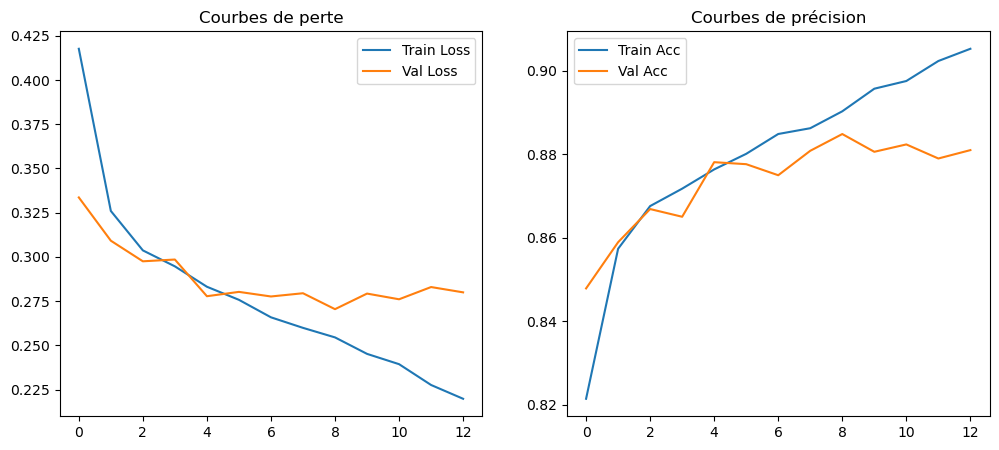

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightCNN().to(device)
criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss : fonction de perte pour des problèmes de classification binaire (ou multi‑étiquette).,Avantage : plus stable numériquement que d’appliquer séparément sigmoid() puis BCELoss().
optimizer = optim.Adam(model.parameters(), lr=1e-3) # optimiseur Adam (Adaptive Moment Estimation), qui ajuste les learning rates de chaque paramètre de manière adaptative.,tous les paramètres (poids, biais) du modèle seront mis à jour par l’optimiseur., learning rate initial fixé à 0.001, contrôlant la taille des pas de mise à jour à chaque itération.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True) #Réduit le learning rate si la perte de validation ne s’améliore pas pendant 3 epochs, en multipliant le learning rate par 0.1 (facteur de réduction).

best_loss = float('inf')# initialiser la meilleure perte à l'infini pour la première comparaison
patience, wait = 7, 0 # patience : nombre d'epochs sans amélioration avant d'arrêter l'entraînement
num_epochs = 13 # nombre d'epochs d'entraînement

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    # --- Phase d'entraînement ---
    model.train()
    running_loss, correct, total = 0, 0, 0 #initialiser les variables pour l'entraînement"
    for imgs, tabs, labs in train_loader:
        if len(imgs) == 0: continue
        imgs, tabs, labs = imgs.to(device), tabs.to(device), labs.to(device)
        optimizer.zero_grad() #remettre à zéro les gradients avant la rétropropagation
        out = model(imgs, tabs) #passer les images et les données tabulaires dans le modèle
        loss = criterion(out, labs) #calculer la perte entre les sorties du modèle et les labels
        loss.backward() #rétropropagation de la perte pour calculer les gradients
        optimizer.step() #mettre à jour les poids du modèle en fonction des gradients calculés
        running_loss += loss.item() #accumuler la perte
        preds = (torch.sigmoid(out) > 0.5).float() #appliquer la fonction sigmoïde pour obtenir des probabilités, puis binariser les prédictions (0 ou 1) en utilisant un seuil de 0.5
        correct += (preds == labs).sum().item() #compter le nombre de prédictions correctes
        total += labs.numel() #totaliser le nombre d'échantillons traités

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # --- Phase de validation ---
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, tabs, labs in val_loader:
            if len(imgs) == 0: continue
            imgs, tabs, labs = imgs.to(device), tabs.to(device), labs.to(device)
            out = model(imgs, tabs)
            val_loss += criterion(out, labs).item()
            preds = (torch.sigmoid(out) > 0.5).float()
            correct += (preds == labs).sum().item()
            total += labs.numel()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    scheduler.step(val_losses[-1])

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss {train_losses[-1]:.4f} | Train Acc {train_accs[-1]:.4f} — "
          f"Val Loss {val_losses[-1]:.4f} | Val Acc {val_accs[-1]:.4f}")

    # Early stopping
    if val_losses[-1] < best_loss:
        best_loss = val_losses[-1]
        torch.save(model.state_dict(), "ecg_classifier_final.pth")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹ Early stopping")
            break

# --- 7) Chargement du meilleur modèle ---
model.load_state_dict(torch.load("ecg_classifier_final.pth"))

# --- 8) Visualisation ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Courbes de perte")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Courbes de précision")
plt.legend()
plt.show()


In [ ]:
model.eval()
test_loss, correct, total = 0, 0, 0

with torch.no_grad():
    for imgs, tabs, labs in val_loader:
        if len(imgs) == 0: continue
        imgs, tabs, labs = imgs.to(device), tabs.to(device), labs.to(device)
        out = model(imgs, tabs)
        loss = criterion(out, labs)
        test_loss += loss.item()
        preds = (torch.sigmoid(out) > 0.5).float()
        correct += (preds == labs).sum().item()
        total += labs.numel()

test_loss /= len(val_loader)
test_acc = correct / total

print(f"🧪 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


🧪 Test Loss: 0.2092 | Test Accuracy: 0.9169


In [ ]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, tabs, labs in val_loader:
        if len(imgs) == 0: continue
        imgs, tabs = imgs.to(device), tabs.to(device)
        out = model(imgs, tabs)
        preds = (torch.sigmoid(out) > 0.5).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labs.numpy())

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

print(classification_report(all_labels, all_preds, target_names=target_columns))


                             precision    recall  f1-score   support

 Myocardial Infarction (MI)       0.79      0.35      0.49       214
         ST/T Change (STTC)       0.73      0.70      0.72       247
Conduction Disturbance (CD)       0.84      0.75      0.79        83
          Hypertrophy (HYP)       0.88      0.50      0.64       149
              Normal (NORM)       0.91      0.91      0.91       565

                  micro avg       0.85      0.71      0.78      1258
                  macro avg       0.83      0.64      0.71      1258
               weighted avg       0.85      0.71      0.76      1258
                samples avg       0.67      0.64      0.65      1258



c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


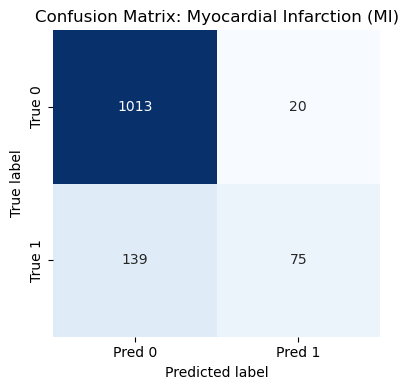

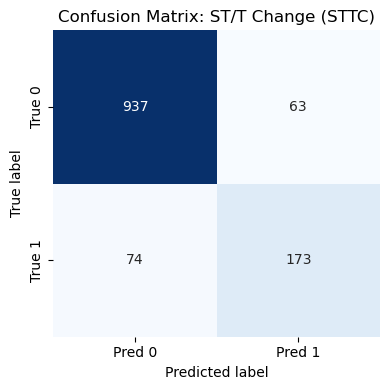

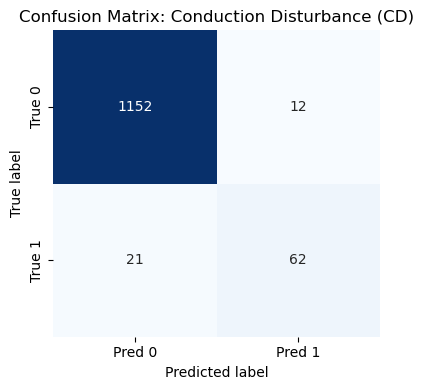

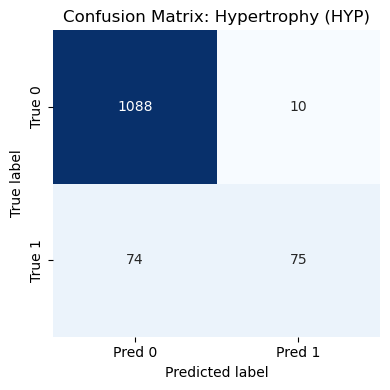

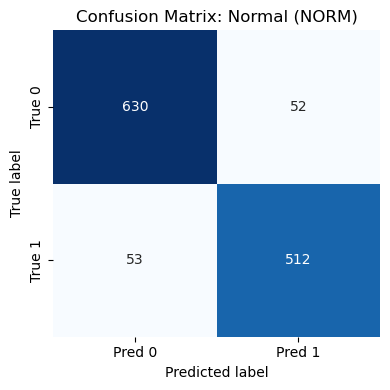

In [19]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 2. Matrices de confusion multilabel ---
mcm = multilabel_confusion_matrix(all_labels, all_preds)

# --- 3. Affichage ---
for i, label in enumerate(target_columns):
    tn, fp, fn, tp = mcm[i].ravel()
    matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(4, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix: {label}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

In [3]:
pip install torchviz


In [5]:
# --- 5) Modèle CNN Léger ---
class LightCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        def dw_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c),
                nn.BatchNorm2d(in_c),
                nn.ReLU(),
                nn.Conv2d(in_c, out_c, kernel_size=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
        self.conv1 = dw_conv(3, 16)
        self.conv2 = dw_conv(16, 32)
        self.conv3 = dw_conv(32, 64)

        self.cnn_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.mlp = nn.Sequential(
            nn.Linear(4, 16), nn.BatchNorm1d(16), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 32), nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 + 32, 64), nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, len(target_columns))
        )

    def forward(self, img, tab):
        x = self.conv1(img)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.cnn_fc(x)
        y = self.mlp(tab)
        return self.classifier(torch.cat([x, y], dim=1))
  
target_columns = [
    "Myocardial Infarction (MI)", "ST/T Change (STTC)",
    "Conduction Disturbance (CD)", "Hypertrophy (HYP)", "Normal (NORM)"
]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightCNN().to(device)
model.load_state_dict(torch.load("ecg_classifier_final.pth", map_location=device))
model.eval()


C:\Users\pc\AppData\Local\Temp\ipykernel_3080\1484643037.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ecg_classifier_final.pth", map

LightCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 

In [5]:
# Créez une entrée d'exemple
from torchviz import make_dot

img = torch.randn(1, 3, 128, 128)  # Exemple d'image de taille 64x64 (ajustez si nécessaire)
tab = torch.randn(1, 4)  # Exemple de données tabulaires (4 features)
img = img.to(device)
tab = tab.to(device)

# Passez l'entrée à travers le modèle
output = model(img, tab)

# Créez le graphique et sauvegardez-le en PNG
make_dot(output, params=dict(model.named_parameters())).render("model_architecture", format="png")

'model_architecture.png'

In [9]:

from PIL import Image
from torchvision import transforms
import torch

# Même transform que pour l'entraînement
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Exemple : prédiction pour une image
img_path = r"records100\00016_lr.png"  # change selon ton cas
image = Image.open(img_path).convert("RGB")
image = image_transform(image).unsqueeze(0).to(device)  # (1, 3, 128, 128)

# Données tabulaires associées (âge, sexe, taille, poids)
tab_data = torch.tensor([[68.0,0.0,0.0,0.0]], dtype=torch.float32).to(device)  # 1 ligne

# --- Prédiction ---
with torch.no_grad():
    output = model(image, tab_data)
    probs = torch.sigmoid(output).cpu().numpy()[0]

In [10]:
# Affichage des résultats
for label, prob in zip(target_columns, probs):
    print(f"{label}: {prob:.2f}")

Myocardial Infarction (MI): 0.16
ST/T Change (STTC): 0.11
Conduction Disturbance (CD): 0.00
Hypertrophy (HYP): 0.00
Normal (NORM): 0.51


# chercher meilleure seuil 

In [ ]:

def compute_predictions_and_labels(df, image_dir):
    """
    Parcourt le DataFrame, charge les images existantes et récupère :
      - all_probs : probabilités prédites pour chaque image,
      - y_true : labels réels (binaire) pour chaque image.
    """
    y_true = []
    all_probs = []
    found = 0

    for idx, row in df.iterrows():
        img_path = row["filename_lr"]
        if not os.path.exists(img_path):
            continue  # image non trouvée, passer à la suivante
        
        try:
            # Chargement et transformation de l'image
            image = Image.open(img_path).convert("RGB")
            image = image_transform(image).unsqueeze(0).to(device)
            
            # Préparation des données tabulaires (âge, sexe, taille, poids)
            tab_data = torch.tensor([[row['age'], row['sex'], row['height'], row['weight']]],
                                    dtype=torch.float32).to(device)
            
            # Prédiction
            with torch.no_grad():
                output = model(image, tab_data)
                probs = torch.sigmoid(output).cpu().numpy()[0]
            
            all_probs.append(probs)
            true_labels = row[target_columns].values.astype(int)
            y_true.append(true_labels)
            found += 1

        except Exception as e:
            print(f"Erreur pour l'image {img_path} : {e}")
    
    if found == 0:
        raise ValueError("Aucune image trouvée dans le dossier spécifié.")
    
    print(f"{found} images traitées.")
    return np.array(y_true), np.array(all_probs)

def determine_best_threshold(y_true, all_probs):
    """
    Parcourt plusieurs seuils entre 0 et 1 pour déterminer celui qui maximise le F1 score macro.
    """
    best_threshold = 0.0
    best_f1 = 0.0

    # Teste 101 seuils de 0.0 à 1.0
    for t in np.linspace(0, 1, 101):
        y_pred = (all_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    
    print(f"Meilleur seuil déterminé : {best_threshold} avec un F1 score = {best_f1}")
    return best_threshold

def evaluate_model_and_determine_threshold(df, image_dir):
    """
    Fonction principale qui :
      - récupère les labels réels et probabilités prédites,
      - détermine automatiquement le meilleur seuil,
      - affiche le rapport de classification final avec ce seuil.
    """
    y_true, all_probs = compute_predictions_and_labels(df, image_dir)
    best_threshold = determine_best_threshold(y_true, all_probs)
    
    # Calcul final avec le seuil optimal
    y_pred = (all_probs >= best_threshold).astype(int)
    
    print("\nRapport de classification final :")
    print(classification_report(y_true, y_pred, target_names=target_columns, zero_division=0))
    
    return best_threshold, y_true, y_pred

# Exemple d'utilisation :
best_threshold, y_true, y_pred = evaluate_model_and_determine_threshold(df, image_dir)


C:\Users\pc\AppData\Local\Temp\ipykernel_4684\3310757987.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ecg_classifier_final.pth", ma

12466 images traitées.
Meilleur seuil déterminé : 0.34 avec un F1 score = 0.7335654079114008

Rapport de classification final :
                             precision    recall  f1-score   support

 Myocardial Infarction (MI)       0.56      0.63      0.59      2314
         ST/T Change (STTC)       0.58      0.83      0.69      2453
Conduction Disturbance (CD)       0.70      0.91      0.79       931
          Hypertrophy (HYP)       0.73      0.69      0.71      1377
              Normal (NORM)       0.83      0.95      0.88      5510

                  micro avg       0.71      0.84      0.77     12585
                  macro avg       0.68      0.80      0.73     12585
               weighted avg       0.71      0.84      0.77     12585
                samples avg       0.70      0.73      0.70     12585



In [21]:

# Fonction de prédiction
def predict_sample(img_path, tab_data, model, threshold=0.34):
    image = Image.open(img_path).convert("RGB")
    image_tensor = image_transform(image).unsqueeze(0).to(device)

    tab_tensor = torch.tensor(tab_data, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor, tab_tensor)
        probs = torch.sigmoid(output).cpu().numpy().flatten()

    preds_binary = (probs > threshold).astype(int)
    return probs, preds_binary


=== Exemple 1 ===
Image: records100\04130_lr.png
Classe                                   |  Réel  |   Prédit (proba)  
----------------------------------------------------------------------
Myocardial Infarction (MI)               |   0    | 0.23 (=> 0)
ST/T Change (STTC)                       |   1    | 0.62 (=> 1)
Conduction Disturbance (CD)              |   0    | 0.00 (=> 0)
Hypertrophy (HYP)                        |   0    | 0.11 (=> 0)
Normal (NORM)                            |   0    | 0.03 (=> 0)


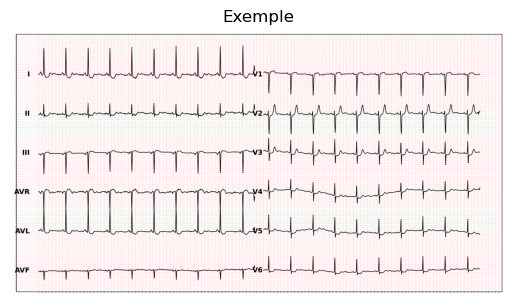


=== Exemple 2 ===
Image: records100\01696_lr.png
Classe                                   |  Réel  |   Prédit (proba)  
----------------------------------------------------------------------
Myocardial Infarction (MI)               |   1    | 0.35 (=> 1)
ST/T Change (STTC)                       |   0    | 0.46 (=> 1)
Conduction Disturbance (CD)              |   0    | 0.00 (=> 0)
Hypertrophy (HYP)                        |   0    | 0.04 (=> 0)
Normal (NORM)                            |   0    | 0.01 (=> 0)


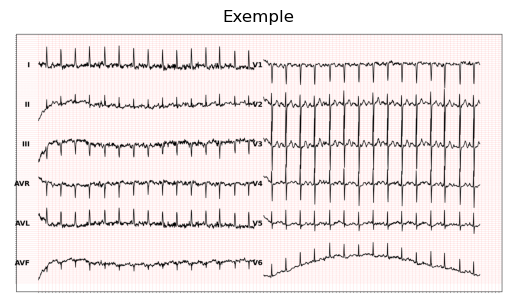


=== Exemple 3 ===
Image: records100\06007_lr.png
Classe                                   |  Réel  |   Prédit (proba)  
----------------------------------------------------------------------
Myocardial Infarction (MI)               |   0    | 0.01 (=> 0)
ST/T Change (STTC)                       |   0    | 0.01 (=> 0)
Conduction Disturbance (CD)              |   0    | 0.00 (=> 0)
Hypertrophy (HYP)                        |   0    | 0.02 (=> 0)
Normal (NORM)                            |   1    | 0.87 (=> 1)


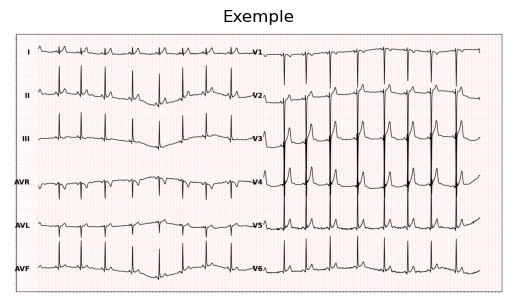


=== Exemple 4 ===
Image: records100\08726_lr.png
Classe                                   |  Réel  |   Prédit (proba)  
----------------------------------------------------------------------
Myocardial Infarction (MI)               |   1    | 0.48 (=> 1)
ST/T Change (STTC)                       |   0    | 0.21 (=> 0)
Conduction Disturbance (CD)              |   0    | 0.03 (=> 0)
Hypertrophy (HYP)                        |   0    | 0.02 (=> 0)
Normal (NORM)                            |   0    | 0.02 (=> 0)


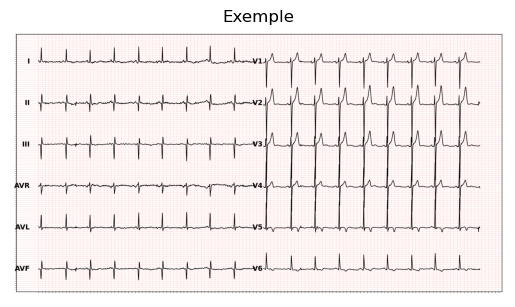

In [ ]:

# Sélectionner 5 exemples à prédire
samples_to_show = df.sample(4, random_state=2).reset_index(drop=True)

for i, row in samples_to_show.iterrows():
    img_path = row["filename_lr"]
    tab_data = [row["age"], row["sex"], row["height"], row["weight"]]

    # Prédire
    probs, preds = predict_sample(img_path, tab_data, model)

    # Affichage
    print(f"\n=== Exemple {i+1} ===")
    print(f"Image: {img_path}")
    print(f"{'Classe':40s} | {'Réel':^6s} | {'Prédit (proba)':^18s}")
    print("-" * 70)
    for j, col in enumerate(target_columns):
        print(f"{col:40s} | {int(row[col]):^6d} | {probs[j]:.2f} (=> {preds[j]})")

    # Affichage de l'image
    image = Image.open(img_path)
    plt.imshow(image)
    plt.title(f"Exemple")
    plt.axis('off')
    plt.show()
